In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import time
import math

In [2]:
class MyGraph:
    def __init__(self, width: int = 5, height: int = 5, max_edge: int = 5):
        self.width = width  # y-axis
        self.height = height  # x-axis
        self.G = nx.from_numpy_array(
            self.construct_random_subgraph(width, max_edges=max_edge),
            create_using=nx.DiGraph(),
        )
        self.adj_matrix = nx.adjacency_matrix(self.G).toarray()
        self.adjacency_dict = {k: list(v) for k, v in self.G.adjacency()}
        self.nodes_list = list(self.G.nodes.keys())
        self.edge_indices = self.calc_node_action_pairs()
        self.action_dim = None
        self.state_dim = None
        self.action_method = None
        self.state_method = None

    def construct_random_subgraph(self, num_nodes, min_edges=2, max_edges=5):
        min_edges -= 1
        max_edges -= 1
        connections = np.random.uniform(size=(num_nodes, num_nodes))
        connections += np.roll(
            np.eye(num_nodes), 1, 1
        )  # make sure every node is connected
        connections -= np.eye(num_nodes)  # make sure no self-connections
        # set strongest connections
        sorted_connections = np.sort(connections)[:, ::-1]
        min_edges = min_edges
        max_edges = max_edges + 1
        min_edges = int(min_edges / 2 + 0.5)  # used to be min_edges // 2
        max_edges = int(max_edges / 2 + 0.5)
        indices = np.stack(
            [np.arange(num_nodes), np.random.randint(min_edges, max_edges, num_nodes)]
        )
        thresholds = sorted_connections[indices[0], indices[1]]
        connections = np.where(connections > thresholds[:, None], 1.0, 0.0).astype(
            np.float32
        )
        connections = np.clip(connections + connections.T, 0, 1)
        return connections

    def calc_node_action_pairs(self) -> dict[(int, int) : int]:
        edge_indices = {}
        for edge_idx, edge in enumerate(self.G.edges()):
            # from_node, to_node = edge
            # from_node_idx = self.nodes_list.index(from_node)
            # to_node_idx = self.nodes_list.index(to_node)
            edge_indices[edge] = edge_idx
        return edge_indices

    def calc_action_between_cur_and_next_node(
        self, curr_node: int, next_node: int
    ) -> int:
        """
        each node has 4 actions: [S, N, W, E]
        """
        curr_x, curr_y = self.nodes_list[curr_node]
        next_x, next_y = self.nodes_list[next_node]
        origin_neighbors = [
            (curr_x + 1, curr_y),
            (curr_x - 1, curr_y),
            (curr_x, curr_y - 1),
            (curr_x, curr_y + 1),
        ]
        action = origin_neighbors.index((next_x, next_y))
        return action

    def random_walk(
        self, num_walks, walk_length, action_method: int = 0, state_method: int = 0
    ):
        """
        action_method:
            0: state-dependent action
            1: state-independent action (4 action)
        state_method:
            0: coordinate-independent state
            1: coordinate-dependent state (x, y)
        """
        self.action_method = action_method
        self.state_method = state_method
        if action_method == 0:  # state-dependent action
            self.action_dim = len(self.edge_indices)
        elif action_method == 1:  # state-independent action (4 action)
            self.action_dim = 4
        else:
            raise AttributeError
        if state_method == 0:  # coordinate-independent state
            self.state_dim = len(self.nodes_list)
        elif state_method == 1:  # coordinate-dependent state (x, y)
            self.state_dim = 2
        else:
            raise AttributeError
        dataset = []
        for _ in range(num_walks):
            curr_node = np.random.choice(len(self.nodes_list))
            for _ in range(walk_length):
                next_node = np.random.choice(
                    np.where(self.adj_matrix[curr_node] != 0)[0]
                ).item()
                action = self.action_node_to_emb(curr_node, next_node)
                curr_node_emb = self.state_int_to_emb(curr_node)
                next_node_emb = self.state_int_to_emb(next_node)
                dataset.append(np.concatenate([curr_node_emb, [action], next_node_emb]))
                curr_node = next_node
        return np.array(dataset)

    def state_int_to_emb(self, state: int) -> np.array:
        if self.state_method == 0:  # coordinate-independent state
            state_emb = np.zeros(self.state_dim)
            state_emb[state] = 1
        elif self.state_method == 1:  # coordinate-dependent state (x, y)
            state_emb = np.array(self.nodes_list[state])
        else:
            raise AttributeError
        return state_emb.astype(np.float32)

    def action_node_to_emb(self, curr_node: int, next_node: int) -> int:
        if self.action_method == 0:  # state-dependent action
            action = self.edge_indices[
                (self.nodes_list[curr_node], self.nodes_list[next_node])
            ]
        elif self.action_method == 1:  # state-independent action (4 action)
            action = self.calc_action_between_cur_and_next_node(curr_node, next_node)
        else:
            raise AttributeError
        return action

In [3]:
class GraphDataset(Dataset):
    def __init__(self, dataset, n_obs):
        self.from_node = (
            torch.from_numpy(dataset[:, :n_obs]).type(torch.float32).to("cuda")
        )
        self.to_node = (
            torch.from_numpy(dataset[:, n_obs + 1 :]).type(torch.float32).to("cuda")
        )
        self.action = torch.from_numpy(dataset[:, n_obs]).type(torch.int).to("cuda")

    def __getitem__(self, index):
        return self.from_node[index], self.action[index], self.to_node[index]

    def __len__(self):
        return len(self.from_node)

In [4]:
def CML_planner(graph: MyGraph, Q, V, start, goal, model):
    node_record = []
    curr = int(start)
    goal_node_emb = graph.state_int_to_emb(goal)
    for i in range(len(graph.nodes_list)):
        node_record.append(curr)
        if curr == goal:
            return i, node_record
        curr_node_emb = graph.state_int_to_emb(curr)
        delta = (
            Q @ goal_node_emb - Q @ curr_node_emb
        )  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(graph.adj_matrix[curr] != 0)[0]  # int64
        # avail_actions = [
        #     graph.action_node_to_emb(curr, next_node) for next_node in avail_nodes
        # ]
        # if not model.use_nn:
        #     utility = delta.T @ V[:, avail_actions]
        # else:
        #     actions = torch.zeros((model.n_act, len(avail_actions)))
        #     for idx, edge in enumerate(avail_actions):
        #         actions[edge, idx] = 1
        #     utility = delta.T @ V(actions.T).numpy().T
        # eligibility = utility / graph.adj_matrix[curr][avail_nodes]
        # dtype = [("id", int), ("value", float)]
        # values = [(idx, value) for idx, value in enumerate(eligibility)]
        # a = np.array(values, dtype=dtype)
        # sorted_arr = np.sort(a, order="value")
        # sorted_arr = sorted_arr[::-1]  # reverse
        # for best_id, _ in sorted_arr:
        #     curr = int(avail_nodes[best_id])
        #     if curr not in node_record:
        #         break
        temp_max = -np.inf
        idx_max = -1
        for next_node in avail_nodes:
            if next_node not in node_record:
                action = graph.action_node_to_emb(curr, next_node)
                utility = delta.T @ V[:, action]
                if utility > temp_max:
                    temp_max = utility
                    idx_max = next_node
        if idx_max == -1:
            print("planning failed")
            raise ValueError
        curr = idx_max
    return i, node_record

In [84]:
class MyNNCML(nn.Module):
    def __init__(
        self,
        emb_dim,
        n_obs,
        n_act,
        Q_init_stddev,
        V_init_stddev,
        W_init_stddev,
    ):
        super().__init__()
        self.n_act = n_act
        self.n_obs = n_obs
        self.Q = nn.Parameter(
            torch.randn(size=(emb_dim, n_obs)) * Q_init_stddev, requires_grad=True
        )
        self.V = nn.Parameter(
            torch.randn(size=(emb_dim, n_act)) * V_init_stddev, requires_grad=True
        )
        self.W = nn.Parameter(
            torch.randn(size=(n_act, emb_dim)) * W_init_stddev, requires_grad=True
        )

    def forward(self, data):
        nodes, action, next_nodes = data
        actions = torch.zeros((self.n_act, len(action))).to("cuda")
        for idx, edge in enumerate(action):
            actions[edge, idx] = 1
            loss1 = self.Q @ next_nodes.T - self.Q @ nodes.T - self.V @ actions
            loss2 = ((self.Q.T @ self.Q) @ nodes.T) - nodes.T
        return loss1, loss2

In [220]:
map_size = 10
my_graph = MyGraph(map_size, map_size, 5)
num_walks = 200
walk_length = map_size
dataset = my_graph.random_walk(num_walks, walk_length, 0, 0)
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
print(n_obs, n_act)
dataset[0]

10 28


array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 8., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0.])

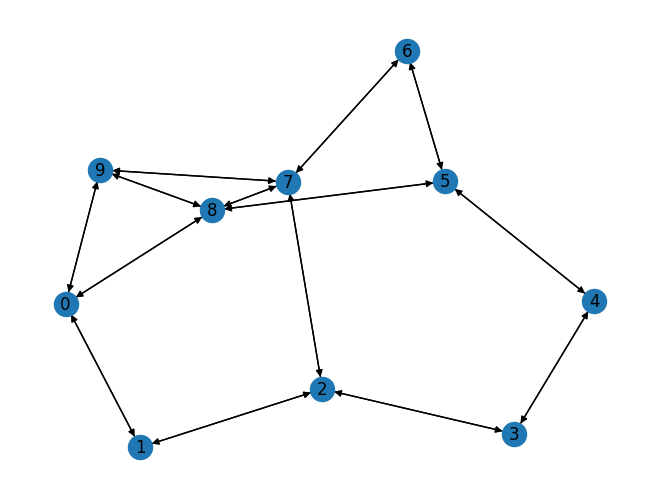

In [234]:
nx.draw(my_graph.G, with_labels=True)

In [242]:
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
emb_dim = 500
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.01
num_epochs = 10
batch_size = num_walks * map_size
dataset_torch = GraphDataset(dataset, n_obs)
n_obs, n_act

(10, 28)

In [245]:
loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
model = MyNNCML(emb_dim, n_obs, n_act, Q_init_stddev, V_init_stddev, W_init_stddev)
optim = torch.optim.Adam(
    params=[
        {"params": model.Q, "lr": eta_q},
        {"params": model.V, "lr": eta_q / 10},
        {"params": model.W, "lr": eta_q / 10},
    ],
    lr=0.01,
)

mses1 = []
writer = SummaryWriter(
    f"""state_only/{str(map_size)}-{str(emb_dim)}-{str(batch_size)}-{int(time.time())}"""
)
global_step = 0

In [248]:
model.to("cuda")
for epoch in range(500):
    for i, data in enumerate(loader):
        # print(i)
        optim.zero_grad()
        output1, output2 = model(data)
        loss = F.mse_loss(output1, torch.zeros_like(output1)) + F.mse_loss(output2, torch.zeros_like(output2))
        loss.backward()
        optim.step()
        global_step += 1
        # with torch.no_grad():
        #     model.V /= model.V.norm(dim=0)
        #     model.V *= math.sqrt(2)
        writer.add_scalar("train loss", loss.detach().item(), global_step)

In [249]:
with torch.no_grad():
    model.cpu()
    Q, V = model.Q.detach().numpy(), model.V.detach().numpy()

In [251]:
with torch.no_grad():
    N_goal = 2000
    cml_distance = []
    cml_succ = 0
    dijkstra_distance = []
    graph = nx.from_numpy_array(
        my_graph.adj_matrix, create_using=nx.DiGraph()
    )  # node_id is int, or else dijkstra will fail
    for process in range(N_goal):
        print(process)
        start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
        goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
        # print(start, goal)

        steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)

        dijkstra_path = nx.shortest_path(
            graph, source=start, target=goal, weight="weight"
        )
        dijkstra_steps = len(dijkstra_path) - 1

        dijkstra_distance.append(dijkstra_steps)
        if o_record[-1] == goal:
            cml_distance.append(steps)
            cml_succ += 1
        if dijkstra_steps < steps:
            print(o_record, dijkstra_path)
            # break
        print(steps, dijkstra_steps)
    print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ)

0
[4, np.int64(5), np.int64(6), np.int64(7), np.int64(2), np.int64(1), np.int64(0)] [4, 5, 8, 0]
6 3
1
[0, np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)] [0, 8, 5]
5 2
2
[6, np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0), np.int64(9)] [6, 7, 9]
7 2
3
[9, np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3)] [9, 7, 2, 3]
5 3
4
[9, np.int64(8), np.int64(0), np.int64(1)] [9, 0, 1]
3 2
5
[7, np.int64(6), np.int64(5), np.int64(4), np.int64(3)] [7, 2, 3]
4 2
6
1 1
7
[1, np.int64(0), np.int64(8), np.int64(5), np.int64(6)] [1, 2, 7, 6]
4 3
8
2 2
9
2 2
10
2 2
11
[5, np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0), np.int64(9)] [5, 8, 9]
6 2
12
[2, np.int64(1), np.int64(0), np.int64(8), np.int64(5), np.int64(4)] [2, 3, 4]
5 2
13
2 2
14
2 2
15
3 3
16
[9, np.int64(8), np.int64(5), np.int64(6)] [9, 7, 6]
3 2
17
1 1
18
1 1
19
[7, np.int64(6), np.int64(5), np.int64(4), np.int64(3)] [7, 2, 3]
4 2
20
[4, np.int64(5), np.int64(6)

In [254]:
delta_dataset = []
for src, tgts in my_graph.adjacency_dict.items():
    for tgt in tgts:
        if tgt > src:
            delta_state = np.zeros(my_graph.state_dim)
            delta_state[src] = -1
            delta_state[tgt] = 1
            delta_dataset.append(delta_state.copy())
delta_dataset_np = np.array(delta_dataset, dtype=np.float32)
delta_dataset_torch = torch.Tensor(delta_dataset_np).to('cuda')

In [257]:
with torch.no_grad():
    model.to('cuda')
    delta_state = delta_dataset_torch[:8]
    delta_state_emb = model.Q@delta_state.T
    delta_state_emb_norm = delta_state_emb / delta_state_emb.norm(dim=0, keepdim=True)
    print(torch.round(delta_state_emb_norm.T@delta_state_emb_norm, decimals=4))
    print(delta_state[:8])
    # print(delta_state_emb_norm.T@delta_state_emb_norm)
    writer.add_text('delta_state_emb_norm.T@delta_state_emb_norm', str(torch.round(delta_state_emb_norm.T@delta_state_emb_norm, decimals=4))+str(delta_state[:8]))
    # model.Q @ dataset_torch

tensor([[ 1.0000,  0.5000,  0.5000, -0.5000,  0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.5000,  1.0000,  0.5000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.5000,  0.5000,  1.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  1.0000, -0.5000, -0.5000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.5000,  1.0000,  0.5000, -0.5000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.5000,  0.5000,  1.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.0000, -0.0000, -0.5000,  0.0000,  1.0000, -0.5000],
        [-0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.5000,  1.0000]],
       device='cuda:0')
tensor([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 

In [259]:
model.V

Parameter containing:
tensor([[-0.0617, -0.0287, -0.0947,  ...,  0.0947,  0.0507,  0.0660],
        [-0.0677, -0.0625, -0.0356,  ...,  0.0356,  0.0574, -0.0269],
        [ 0.0404,  0.0221,  0.0807,  ..., -0.0807, -0.1082, -0.0586],
        ...,
        [ 0.0187,  0.0015,  0.0830,  ..., -0.0830,  0.0144, -0.0815],
        [ 0.0847,  0.1187,  0.0697,  ..., -0.0697,  0.0178,  0.0490],
        [ 0.0241, -0.0756, -0.0189,  ...,  0.0189, -0.0308, -0.0567]],
       device='cuda:0', requires_grad=True)

In [43]:
delta_state[4], delta_state[7]

(tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.], device='cuda:0'),
 tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.], device='cuda:0'))

In [240]:
start = 0
goal = 5
# print(start, goal)

steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)

dijkstra_path = nx.shortest_path(
    graph, source=start, target=goal, weight="weight"
)
dijkstra_steps = len(dijkstra_path) - 1

dijkstra_distance.append(dijkstra_steps)
if o_record[-1] == goal:
    cml_distance.append(steps)
    cml_succ += 1
print(o_record, dijkstra_path)
print(steps, dijkstra_steps)

[0, np.int64(1), np.int64(2), np.int64(7), np.int64(6), np.int64(5)] [0, 8, 5]
5 2
